# Part 1 - INTRODUCTION


Heart disease describes a variety of related conditions such as Coronary Artery Disease, Acute coronary syndrome, Angina, and Aortic Anuerism. Heart disease can lead to numerous detrimental or fatal conditions such as diabetes, heart failure, and heart attack.

It is the leading cause of death in the Unites States, according to the CDC. Roughly 660,000 - 700,00 people in the US die each year from heart disease, which is about one-quarter of all yearly deaths. Approximately 18 million people wordwide die due to heart disease annually, which is about 32% of all deaths.

Given the disease's prevelence and series symptoms, doctors are collecting data from patients to assess a patient's risk for heart disease and prevent it if possible. In this analysis, I will use a set of patient data and use it to predict a patient's risk for having heart disease.

To do this, I will clean data and then utilize different machine learning models to predict a patient's risk of having heart disease. I will then take the most successful model and deploy it so others could, in theory, use it to predict this risk in real time. The deployed model can be accessed via this link: <a href="https://heart-disease-prediction-ak.herokuapp.com/
">Heart Disease Prediction Website</a>

### ---- Results ----

After running several different models on the data, I determined that a random forest model was best able to predict heart disease risk with an accuracy of 96.6% and F1 score of 96.8%. With this finding, I then deployed the model to Heroku so others could (theoretically) use it for prediction purposes.

### ---- Data Source and Notes ----

Data source: https://www.kaggle.com/johnsmith88/heart-disease-dataset/version/2

Data column dictionary:

1. age
2. sex
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

### ---- Import Libraries for Project ----


In [204]:
#analysis and viz imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#data preparation imports
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

#ML model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#metric and analysis imports
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.inspection import permutation_importance

#deployment imports
import joblib

In [206]:
joblib.__version__

'0.17.0'

## Part 2 - Data Preparation And Exploration

### ---- Load Data ----


In [2]:
heart_disease_data = pd.read_csv("./heart.csv")

In [159]:
#use the head method to get a glimpse of the data structure before moving forward
heart_disease_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
527,62,0,0,124,209,0,1,163,0,0.0,2,0,2,1
359,53,0,2,128,216,0,0,115,0,0.0,2,0,0,1
447,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
31,50,0,1,120,244,0,1,162,0,1.1,2,0,2,1
621,48,1,0,130,256,1,0,150,1,0.0,2,2,3,0


### ---- Clean Data ----


First, I will check whether there are any missing values in any of the data rows.

In [4]:
heart_disease_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


The above table shows that there are no null values in the dataset, so nulls do not have to be removed/infilled. 

Next I will view the description of the dataset. In the data description, the data uploader indicates that certain variables are boolean, some range for 0-3, and others like age have some common limits like age not being negative. I will use this data and check data ranges to make sure data is within proper bounds.

In [18]:
heart_disease_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [173]:
heart_disease_data["cp"].unique()

array([0, 2, 1, 3], dtype=int64)

In [174]:
heart_disease_data["fbs"].unique()

array([0, 1], dtype=int64)

In [175]:
heart_disease_data["restecg"].unique()

array([1, 0, 2], dtype=int64)

In [177]:
heart_disease_data["exang"].unique()

array([0, 1], dtype=int64)

In [178]:
heart_disease_data["slope"].unique()

array([2, 1, 0], dtype=int64)

In [179]:
heart_disease_data["ca"].unique()

array([0, 1, 2, 4, 3], dtype=int64)

In [180]:
heart_disease_data["thal"].unique()

array([2, 0, 3, 1], dtype=int64)

In [181]:
heart_disease_data["target"].unique()

array([1, 0], dtype=int64)

Looking at the data, all columns have data within reasonable limits and no corrections need to be made.

Next I will shuffle the data, according to the target variable, to help randomize distribution into train and test data sets.

In [5]:
#shuffle data, to ensure that target variable rows are randomly dispersed. This may help when splitting into 
#test and train sets

heart_disease_data = shuffle(heart_disease_data,random_state=42)

I will also check the distribution of the target variable in the data. If data is imbalanced, we may need to take additional steps in our analysis to account for this.

In [6]:
#Check the distribution of the target variable in this data. If the target is imbalanced, additional steps may 
#need to be taken accordingly

heart_disease_data['target'].value_counts(normalize=True)

1    0.513171
0    0.486829
Name: target, dtype: float64

According to the above calculation, the target variable distribution in this data is roughly a 50/50 split between the 0 and 1 value. Since there isn't a clear imbalance, we can proceed without additional measures.

### ---- Explore the data (EDA) ----

In this classification task, I want to search for correlations between variables and especially with the target variable. To do so I will use a heatmap and correlation matrix.

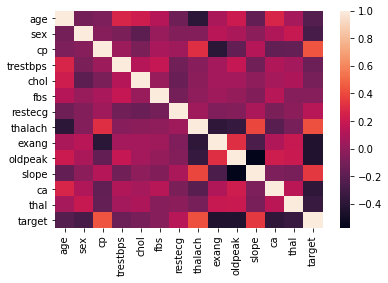

In [7]:
sns.heatmap(heart_disease_data.corr());

In the correlation matrix / heat map, I see that there may be correlations bewteen the target variable and the age, sex, exang, oldpeak, ca and thal variables. At this point I cannot discount any variables yet, but it is helpful to keep these in mind going forward.

### ---- Hypothesize a Solution ----

In the next parts of this analysis, I will attempt to classify the given data points and predict whether a given patient has heart disease. To do so, I will test three models:

1. Random Forest Classifier
2. KNN Classifier
3. Logistic Regression Classifier

# Part 3 Develop a Model

### ---- Split Data For Models ----


In [8]:
X=heart_disease_data.drop('target',axis=1)
y=heart_disease_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

### ---- Create Models ----


#### ---- Training Template ----

Below I will create a function to take the test/train data and a model, fit the model to the data, use the model to predict on the data, and return final metric results. This will yield to less redundancy in the code below.

I will test the data on three different models:
1. Random Forest - a random forest is simple but often powerful in classifying data, and can yield important data about which features are most important
2. KNN - the KNN model could be useful if data points for our classes tend to fall into clusters near each other
3. Logistic Classifier - Logistic classifiers are easy to interpret and the threshold between 0/1 can be adjusted to best fit the data and to meet the overall project needs

The metrics I have chosen for this analysis are accuracy, precision, recall and F1 score. These metrics will help me determine whether a given model is correctly classifying data, how the data performs on positive (target=1) results, and what percent of positive instances were actually predicted to be positive.

In [138]:
def run_model(X_test,X_train, y_test,y_train, model):
    model.fit(X_train,y_train)
    y_pred_class = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    plot_confusion_matrix(model,X_test,y_test,cmap='coolwarm')
    
    #Accuracy ((# of correct classifactions out of all attempted classifications))
    accuracy=accuracy_score(y_test,y_pred_class)
    
    # Precision (of all observations that were predicted +, how many were actually +)
    precision=precision_score(y_test,y_pred_class)
    
    #Recall (of all + observations, how many did we predict as +)
    recall=recall_score(y_test,y_pred_class)
    
    #f1 score (harmonic mean of recall and precision)
    f1=f1_score(y_test,y_pred_class)
    
    nl='\n'
    return (print(f'Model: {model} {nl}accuracy: {accuracy} {nl}precision: {precision} {nl}recall: {recall} {nl}F1 score: {f1}'))

#### ---- Random Forest Model ----

Below I will create an instance of a random forest model, and then use my run_model function to see how it performs on the provided data.


In [139]:
random_forest_clf = RandomForestClassifier(random_state=42,n_estimators=500)

Model: RandomForestClassifier(n_estimators=500, random_state=42) 
accuracy: 0.9658536585365853 
precision: 0.9375 
recall: 1.0 
F1 score: 0.967741935483871


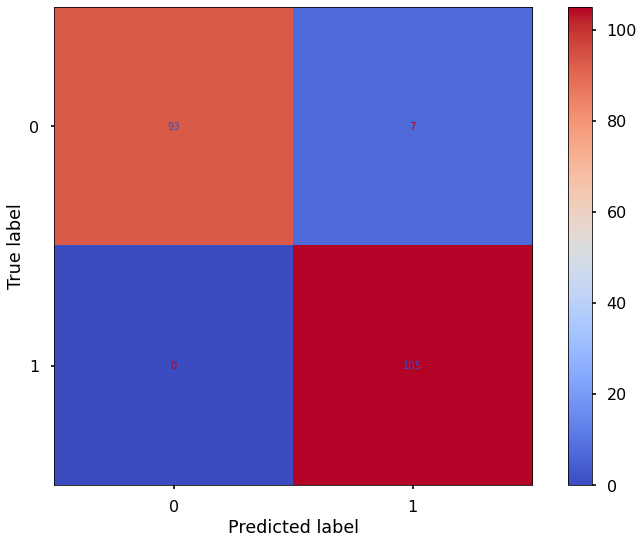

In [140]:
run_model(X_test,X_train, y_test,y_train, random_forest_clf)

In addition to the above metrics, I would also like to know which features appear to be most important in the random forest when classifying this data. To determine this, I will find the permutation importance of each feature and plot it for easier analysis.

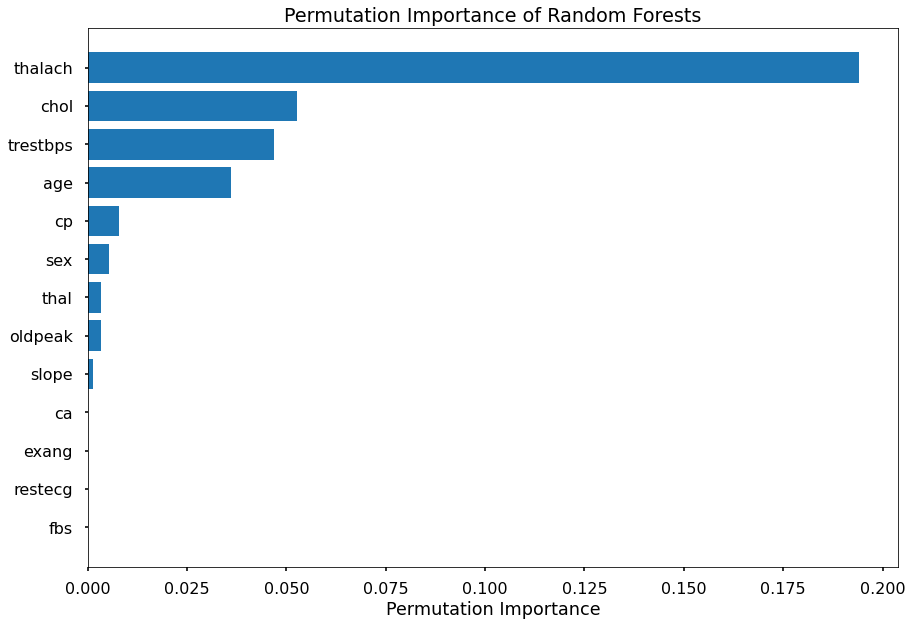

In [39]:
################################################
## Permutation feature importance 
################################################
result = permutation_importance(clf,X_test, y_test, n_repeats=10,random_state=42)

permutation_importance=pd.DataFrame(result['importances_mean'])
feature_names=pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names,permutation_importance],axis=1)
permutation_importance_summary.columns = ['input_variable','permutation_importance']
permutation_importance_summary.sort_values(by='permutation_importance', inplace=True)

plt.barh(permutation_importance_summary['input_variable'],permutation_importance_summary['permutation_importance'])
plt.title("Permutation Importance of Random Forests")
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.show()


As shown above, it appears that max heart rate achieved (thalach) is the most important factor in this model, followed by cholestorol level, resting blood pressure and age.

#### ---- KNN Model ----

Below I will create an instance of a KNN model, and then use my run_model function to see how it performs on the provided data.


In [170]:
knn_clf = KNeighborsClassifier(n_neighbors=2)
# knn_clf.fit(X_train,y_train)

KNN models often work better when data is scaled, since it makes predictions based on the distance between points. Thus before running the model, I will use a MinMaxScaler to normalize the test data.

In [171]:
scaler = MinMaxScaler()
X_train_knn = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns) #return as df
X_test_knn = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns) #return as df

Model: KNeighborsClassifier(n_neighbors=2) 
accuracy: 0.9609756097560975 
precision: 0.9619047619047619 
recall: 0.9619047619047619 
F1 score: 0.9619047619047619


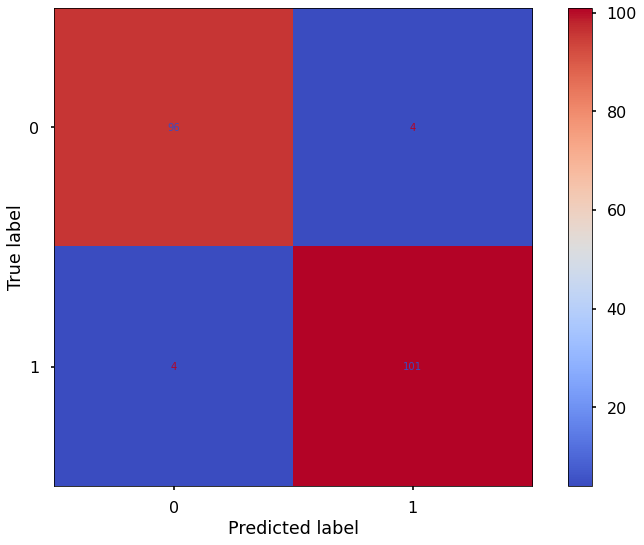

In [172]:
run_model(X_test_knn,X_train_knn, y_test,y_train, knn_clf)

While conducting my KNN analysis, I want to make sure that the model I use is using an optimal number of neighbors in its calculations. To do so, I will runn the KNN model on a range of n_neighbors values and use the one with the best resulting F1 score.

As shown below, this value ends up being 2; 2 is used in the KNN model above accordingly.

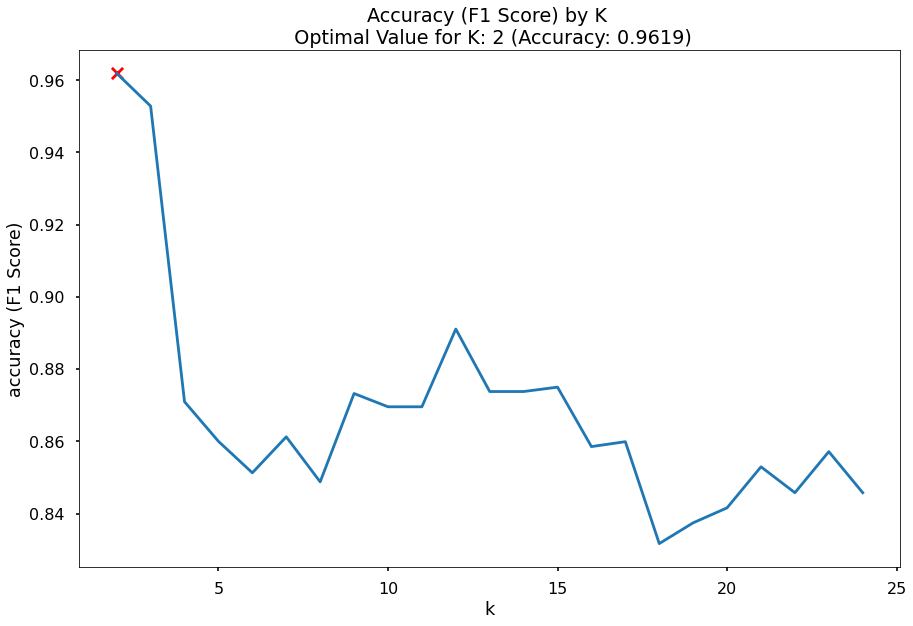

In [182]:
################################################
## Finding optimal value of K
################################################

k_list = list(range(2,25))

accuracy_scores= []
for k in k_list:
    clf= KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_knn,y_train)
    y_pred=clf.predict(X_test_knn)
    accuracy = f1_score(y_test,y_pred)
    accuracy_scores.append(accuracy)

max_accuracy = max(accuracy_scores)
max_accuracy_idx = accuracy_scores.index(max_accuracy)
optimal_k_value = k_list[max_accuracy_idx]

#plot of max depths

plt.plot(k_list,accuracy_scores)
plt.scatter(optimal_k_value,max_accuracy,marker='x',color='red')
plt.title(f"Accuracy (F1 Score) by K \n Optimal Value for K: {optimal_k_value} (Accuracy: {round(max_accuracy,4)})")
plt.xlabel('k')
plt.ylabel('accuracy (F1 Score)')
plt.tight_layout()
plt.show()



#### ---- Logistic Model ----

Below I will create an instance of a logisitic regression classifier model, and then evaluate the model to see how it performs on the provided data.

In [89]:
logistic_clf = LogisticRegression(random_state=42,max_iter=1000)

Before running the model, I will first use Recursive Feature Elimination and Cross-Validation Selection, which will eliminate variables that are irrelevant based on validation scores. This will be done with the RCECV function, and the X train and test data will be adjusted accordingly.

In [90]:
################################################
## Feature Selection
################################################
feature_selector = RFECV(logistic_clf, cv=5)
fit=feature_selector.fit(X_train,y_train)

In [91]:
optimal_feature_count = feature_selector.n_features_
print(f'the optimal number of features is: {optimal_feature_count}')

the optimal number of features is: 8


In [98]:
X_train_log = X_train.loc[:,feature_selector.get_support()]
X_test_log = X_test.loc[:,feature_selector.get_support()]

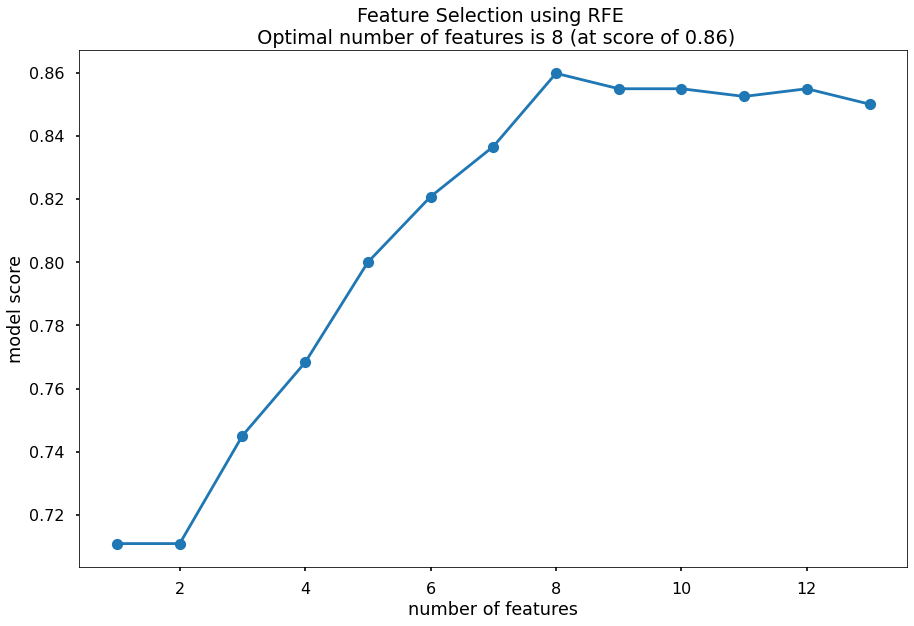

In [207]:
plt.plot(range(1,len(fit.grid_scores_)+1),fit.grid_scores_,marker='o')
#range used so x axis goes from 1 to 4 features rather than starting at 0
#second fit is the scores for each number of vars
plt.ylabel("model score")
plt.xlabel('number of features')
plt.title(f'Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.grid_scores_),3)})')
plt.tight_layout()
plt.show()

Now that the optimal number of features is determined, I will also find the optimal probability threshold to use. To do this I will run the model on different threshold values from 0-1, calculate precision/recall/F1 scores for the model at these threshold values, and then utilize the threshold that yields the highest F1 score. This is done and results plotted below.

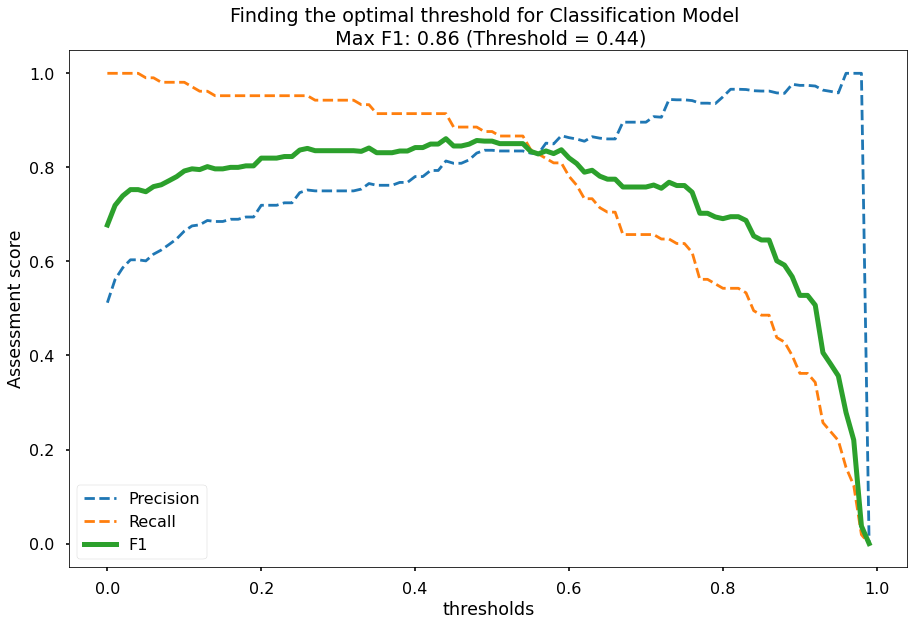

In [150]:
################################################
## Finding optimal probability threshold
################################################

logistic_clf = LogisticRegression(random_state=42,max_iter=1000)
logistic_clf.fit(X_train_log,y_train)
y_pred_class = logistic_clf.predict(X_test_log)
y_pred_proba = logistic_clf.predict_proba(X_test_log)[:,1]

thresholds = np.arange(0,1,0.01) #create an object with a value for each whole %

precision_scores = []
recall_scores = []
f1_scores = []

#loop over thresholds to see which maximizes our metrics
for threshold in thresholds:
    pred_class = (y_pred_proba>=threshold)*1
    precision = precision_score(y_test,pred_class,zero_division=0)
    precision_scores.append(precision)
    
    recall = recall_score(y_test,pred_class)
    recall_scores.append(recall)
    
    f1 = f1_score(y_test,pred_class)
    f1_scores.append(f1)

#find max f1 score
max_f1 = max(f1_scores)
max_f1_index = f1_scores.index(max_f1)

# chart with optimal threshold

plt.style.use("seaborn-poster")
plt.plot(thresholds, precision_scores, label="Precision",ls="--")
plt.plot(thresholds, recall_scores, label="Recall",ls="--")
plt.plot(thresholds, f1_scores, label="F1",lw=5)
plt.title(f"Finding the optimal threshold for Classification Model \n Max F1: {round(max_f1,2)} (Threshold = {round(thresholds[max_f1_index],2)})")
plt.xlabel('thresholds')
plt.ylabel('Assessment score')
plt.legend(loc='lower left')
plt.tight_layout()

In [183]:
# optimal threshold is 0.44
# apply threshold to data

optimal_threshold = 0.44

y_pred_class_opt_thresh = (y_pred_proba>=optimal_threshold)*1

Logistic Model: 
accuracy: 0.848780487804878 
precision: 0.8135593220338984 
recall: 0.9142857142857143 
F1 score: 0.860986547085202
None


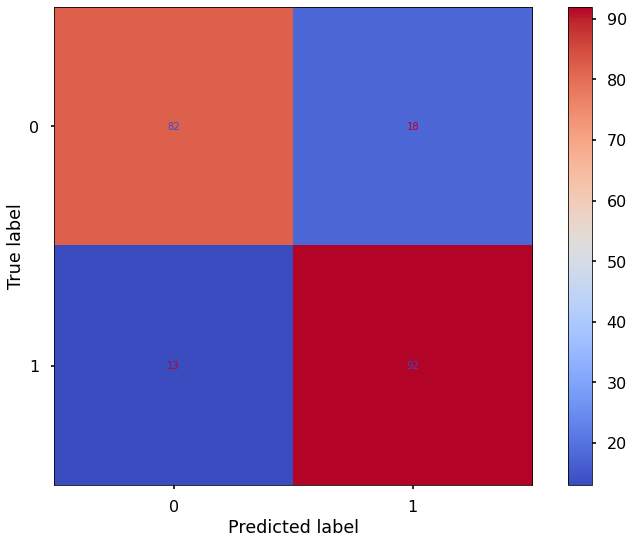

In [161]:
logistic_clf = LogisticRegression(random_state=42,max_iter=1000)
logistic_clf.fit(X_train_log,y_train)
y_pred_class = logistic_clf.predict(X_test_log)
y_pred_proba = logistic_clf.predict_proba(X_test_log)[:,1]
y_pred_class_opt_thresh = (y_pred_proba>=optimal_threshold)*1

plot_confusion_matrix(logistic_clf,X_test_log,y_test,cmap='coolwarm')
    
#Accuracy ((# of correct classifactions out of all attempted classifications))
accuracy=accuracy_score(y_test,y_pred_class_opt_thresh)
    
# Precision (of all observations that were predicted +, how many were actually +)
precision=precision_score(y_test,y_pred_class_opt_thresh)
    
#Recall (of all + observations, how many did we predict as +)
recall=recall_score(y_test,y_pred_class_opt_thresh)
    
#f1 score (harmonic mean of recall and precision)
f1=f1_score(y_test,y_pred_class_opt_thresh)

nl = '\n'
print(print(f'Logistic Model: {nl}accuracy: {accuracy} {nl}precision: {precision} {nl}recall: {recall} {nl}F1 score: {f1}'))

### ---- Select best model  ----


Based on the above analysis, our models yielded the below performane:

|Model|Accuracy|Precision|Recall|F1|
|---|---|---|---|---|
|Random Forest|0.967|0.938|1.0|0.968|
|KNN|0.961|0.962|0.962|0.962|
Logistic Regression|0.849|0.814|0.914|0.861|

Based on the above table, the Logistic Regression model did not perform as well as the other two models in any of the metrics. 

The KNN and random forest models performed similarly, with the random forest model performing better on all the metrics other than Precision.

Precision indicates the following: of all observations that were predicted positive, how many were actually positive. In other words, this indicates the number of true positives that were in the positive class. When considering the impact of this, the random forest model having slightly lower Precision than the KNN model indicates that some patients would be classified as having heart disease and move further into the testing/treatment process though they don't have heart disease. 

Though this is undesriable for those relevant patients, going through more testing or lifestyle changes to lower risk factors isn't as detrminental as not classifying patients with heart disase correctly and having them go untreated.

With this consideration, according to the above analyses the Random Forest model is the best for heart disease classification with these variables.

## Part 4 - DEPLOY

Assuming this model is approved by designated teams for production, doctors or relevant staff will want to use it to help determine whether their patients have heart disease.

To provide this functionality I will:
- save the random forest model to a joblib file
- deploy it to a Flask web interface where staff can input data with the same structure as is provided here
- the interface will then output the likelihood that the patient has heart disease



In [160]:
joblib.dump(random_forest_clf, "heart_disease_model.joblib")

['heart_disease_model.joblib']

The deployed random forest model can be found and used at the following site:

https://heart-disease-prediction-ak.herokuapp.com/

The above site was developed using Flask, and the associated files are found at the github repository below:

https://github.com/akstl1/heart-disease-prediction-deployment

## Part 5 - POTENTIAL FUTURE WORK

In the future, it would be interesting to conduct more analysis to build on the current model and explore heart disease attributes more.

For example, the random forest model permutation importance analysis showed that there were several features that were more prominent than others including age, cholestoral, blood pressure and max heart rate. Honing in on these variables to create new measures/variables. Similarly, groups could study how these variables lead to increased heart disease risk and further help doctors diagnose and prevent heart disease in the future.

It would also be interesting to see longer-term data used in analysis. The dataset provided here had test results at a single point in time, but seeing whether there are additional patterns that map to heart disease risk could be helpful. As companies continue to develop wearable devices that can measure variables like heart rate and blood pressure regularly, developing a way to use wearable device data to help in diagnoses/conduct long term tests could be another way to detect diseases and help patients.

## Part 6 - CONCLUSION

Heart disease is the leading cause of death in the Unites States according to the CDC, killing roughly 660,000 - 700,00 people in the US and approximately 18 million people worldwide annually.

In this analysis, I took a set of patient data with the goal of using it to predict a patient's risk for having heart disease so that they can be treated and have better quality of life overall.

To do this, I first analyzed whether the provided data was clean. Luckily, the original data uploader ensured that this data was of high fidelity.

Next, I created a function to fit a given model to provided data and output performance metrics. After splitting the data into test/train sets, I ran three different models on the test/train data to see which performed best. 

In the end, the random forest model performed best with accuracy of 96.6% and F1 score of 96.8%. Though not perfect this model catches many cases of heart disease, which in turn can lead to patients getting proper treatment and support.